In [1]:
# Import the dependencies
import pandas as pd
import numpy as np
import datetime
import plotly.graph_objects as go

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ORM Stuff
from sqlalchemy import create_engine, inspect, text, func

In [2]:
# Create engine using the `earthquakes.sqlite` database file
engine = create_engine("sqlite:///touristtravel.sqlite")

In [3]:
 # Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within the 'dow' table and its types
for table in tables:
    print(table)
    print("--------")
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

touristtravel
--------
Unnamed: 0 BIGINT
Tourist_ID BIGINT
Country_Visited TEXT
City_Visited TEXT
Mode_of_Travel TEXT
Travel_Duration_Days BIGINT
Number_of_Companions BIGINT
Total_Travel_Cost BIGINT
Accommodation_Type TEXT
Main_Purpose TEXT
Season_of_Visit TEXT
lat FLOAT
long FLOAT



In [4]:
conn = engine.connect() # Raw SQL/Pandas

In [5]:

# Raw SQL Create Data to use for Line Chart comparing Main Purpose of Travel to Total Cost 
query = text("""SELECT
                   *
                FROM
                    touristtravel
                """)
df3 = pd.read_sql(query, con=conn)
df3


,Unnamed: 0,Tourist_ID,Country_Visited,City_Visited,Mode_of_Travel,Travel_Duration_Days,Number_of_Companions,Total_Travel_Cost,Accommodation_Type,Main_Purpose,Season_of_Visit,lat,long
0,0,1,Germany,Hamburg,Flight,8,4,1060,Hotel,Family Visit,Summer,53.550341,10.000654
1,1,2,Germany,Berlin,Car,16,3,3972,Hostel,Family Visit,Winter,52.510885,13.398937
2,2,3,UK,Manchester,Bicycle,8,2,666,Camping,Business,Winter,53.479489,-2.245115
3,3,4,Greece,Thessaloniki,Bicycle,12,3,3644,Hotel,Business,Summer,40.640317,22.935272
4,4,5,Greece,Thessaloniki,Flight,5,3,1885,Airbnb,Leisure,Spring,40.640317,22.935272
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,996,France,Lyon,Bus,20,5,4002,Hotel,Business,Fall,45.757814,4.832011
996,996,997,Switzerland,Geneva,Bus,19,4,2170,Airbnb,Family Visit,Fall,46.201756,6.146601
997,997,998,Austria,Vienna,Car,16,4,1102,Hotel,Leisure,Fall,48.208354,16.372504
998,998,999,UK,Manchester,Flight,14,3,3319,Hotel,Business,Summer,53.479489,-2.245115


In [6]:
# Raw SQL Create Data to use for Line Chart comparing Main Purpose of Travel to Total Cost 
query = text("""SELECT
                   Main_Purpose,
                   SUM(Total_Travel_Cost) AS Total_Cost
                FROM
                    touristtravel
                GROUP BY
                   Main_Purpose
                ORDER BY
                   Total_Cost ASC;""")
df1 = pd.read_sql(query, con=conn)

# Format the Total_Cost column with dollar signs
df1['Total_Cost'] = df1['Total_Cost'].astype(int)

                                        
df1



,Main_Purpose,Total_Cost
0,Leisure,811337
1,Business,863997
2,Family Visit,925042


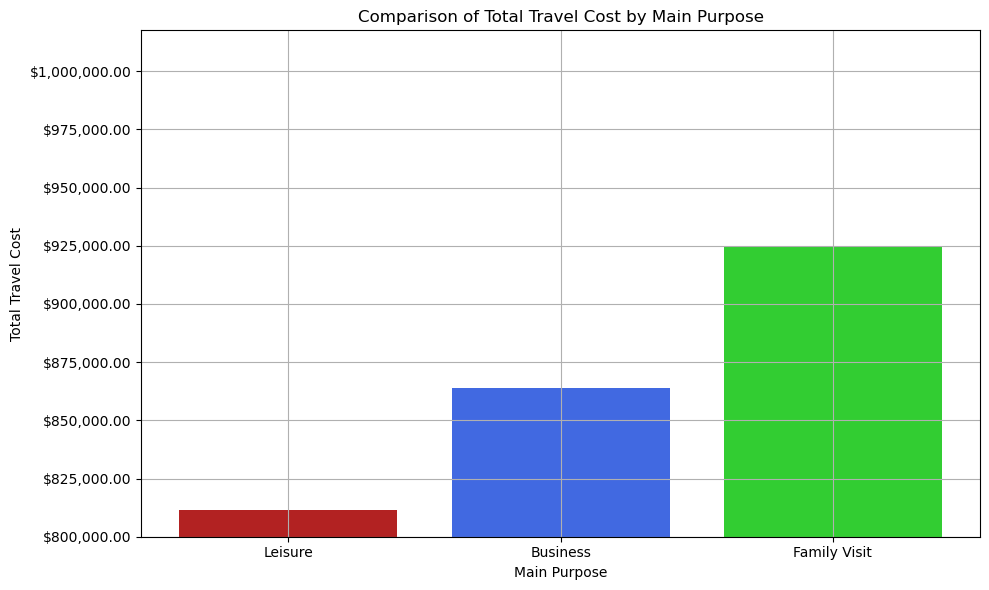

In [7]:
# Create the Bar Chart 


# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(df1['Main_Purpose'], df1['Total_Cost'], color=['firebrick', 'royalblue', 'limegreen'])
plt.title("Comparison of Total Travel Cost by Main Purpose")
plt.xlabel("Main Purpose")
plt.ylabel("Total Travel Cost")

# Setting the y-axis limit before applying currency formatting
plt.ylim(800000, df1['Total_Cost'].max() * 1.1)  # Setting the y-axis limit

# Formatting the y-axis to show currency format
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"${x:,.2f}"))
plt.grid(True)
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlapping
# Save the figure
plt.savefig('travel_cost_chart.png', format='png', dpi=300)
plt.show()



In [8]:
## Create Line Chart -Travel Cost in comparrison to Accomidation 




query = text("""
    SELECT
        Mode_of_Travel,
        Main_Purpose,
        COUNT(*) AS Travel_Count
    FROM
        touristtravel
    GROUP BY
        Mode_of_Travel,
        Main_Purpose
    ORDER BY
        Main_Purpose;
""")

df2 = pd.read_sql(query, con=conn)

df2



,Mode_of_Travel,Main_Purpose,Travel_Count
0,Bicycle,Business,80
1,Bus,Business,64
2,Car,Business,54
3,Flight,Business,80
4,Train,Business,63
5,Bicycle,Family Visit,69
6,Bus,Family Visit,59
7,Car,Family Visit,71
8,Flight,Family Visit,79
9,Train,Family Visit,68


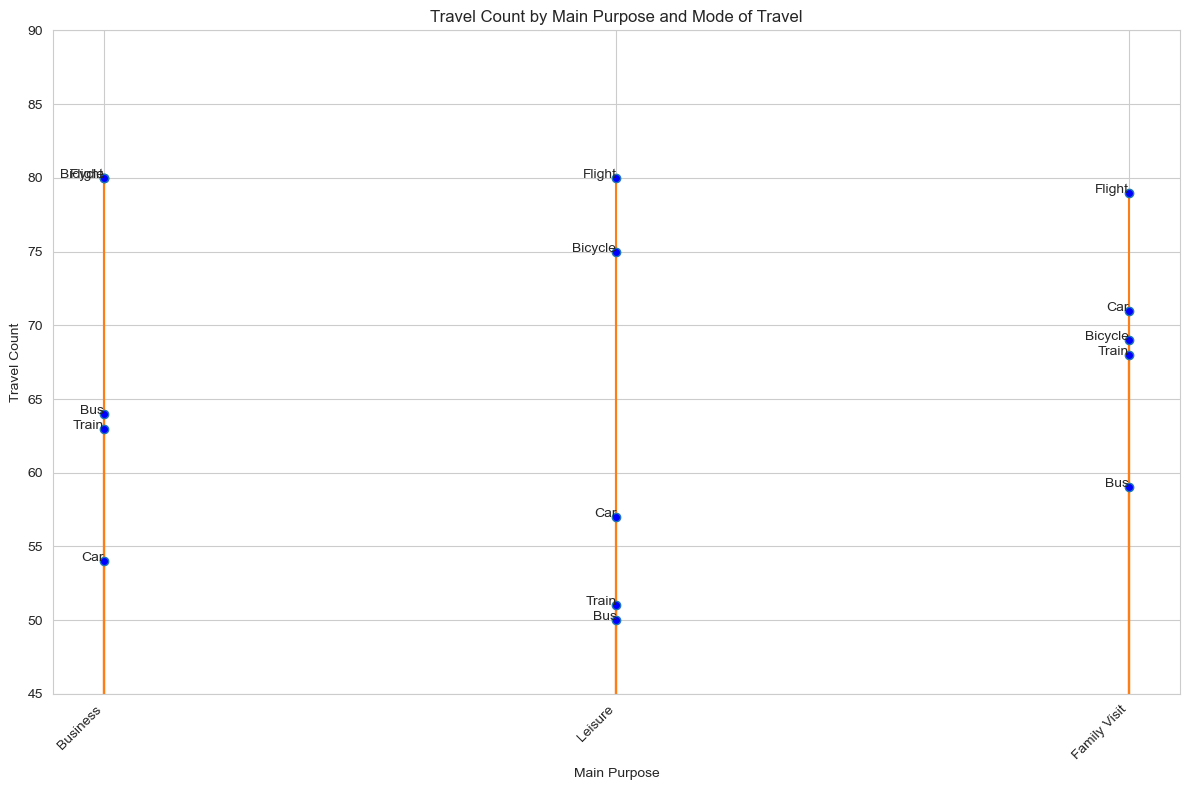

In [9]:
## ATEMPT TO MAKE A LINE CHART, NOT HAPPY WITH LOOK 
# Sorting the DataFrame by Travel_Count for better visualization
df2_sorted = df2.sort_values(by='Travel_Count', ascending=False)

# Create the lollipop chart
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Plotting
(markerline, stemlines, baseline) = plt.stem(df2_sorted['Main_Purpose'], df2_sorted['Travel_Count'], basefmt=" ")

# Customizing the appearance
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(stemlines, 'color', '#fd7e14',)
plt.setp(baseline, 'color', '#0096', 'linewidth', 20)

# Setting y-axis to start at 50
plt.ylim(45, df2_sorted['Travel_Count'].max() + 10)  # Adding a bit of space above the max value

# Adding labels and title
plt.xlabel('Main Purpose')
plt.ylabel('Travel Count')
plt.title('Travel Count by Main Purpose and Mode of Travel')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adding Mode_of_Travel as labels for each lollipop
for i, row in df2_sorted.iterrows():
    plt.text(row['Main_Purpose'], row['Travel_Count'], row['Mode_of_Travel'], horizontalalignment='right')

plt.tight_layout()
plt.show()




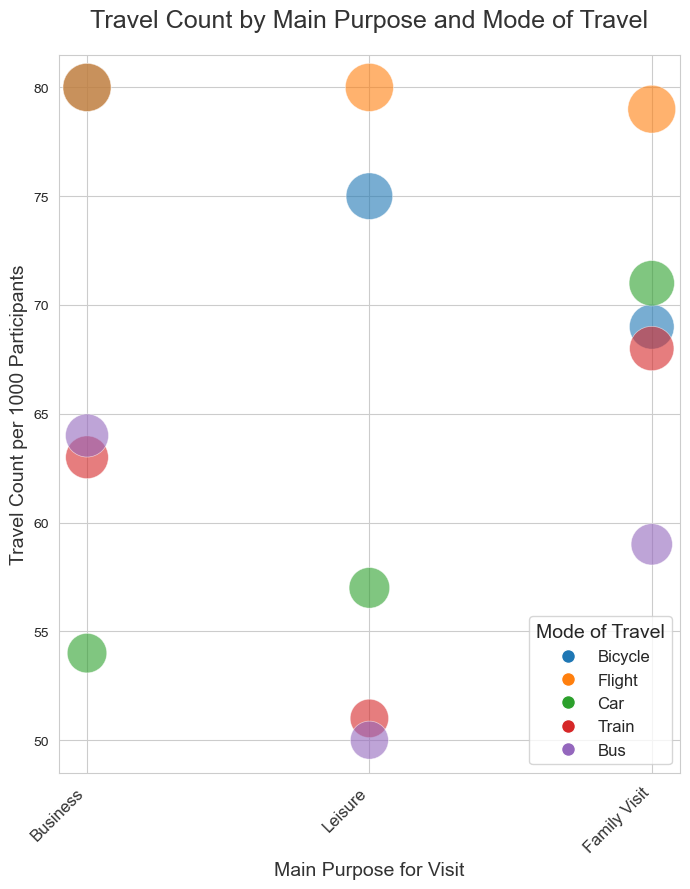

In [10]:

import matplotlib.pyplot as plt
import seaborn as sns

# Sorting the DataFrame by Travel_Count for better visualization
df2_sorted = df2.sort_values(by='Travel_Count', ascending=False)

# Create a color map for different modes of transportation
unique_modes = df2_sorted['Mode_of_Travel'].unique()
color_map = {mode: plt.cm.tab10(i) for i, mode in enumerate(unique_modes)}

# Create the bubble chart
plt.figure(figsize=(7, 9))
sns.set_style("whitegrid")

# Plotting the bubbles
for mode in unique_modes:
    subset = df2_sorted[df2_sorted['Mode_of_Travel'] == mode]
    plt.scatter(subset['Main_Purpose'], subset['Travel_Count'], 
                s=subset['Travel_Count'] * 15,  # Adjusted the bubble size scaling
                color=color_map[mode], alpha=0.6, edgecolor='w', linewidth=0.5, label=mode)

# Adding labels and title
plt.xlabel('Main Purpose for Visit', fontsize=14, color='#333333')
plt.ylabel('Travel Count per 1000 Participants', fontsize=14, color='#333333')
plt.title('Travel Count by Main Purpose and Mode of Travel', fontsize=18, color='#333333', pad=20)

# Rotating the x-axis labels for better readability and reducing the gap
plt.xticks(rotation=45, ha='right', fontsize=12, color='#333333')

# Adjusting the space between labels
plt.gca().xaxis.set_tick_params(pad=5)

# Adding a custom legend with smaller bubbles
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[mode], markersize=10, label=mode) 
                   for mode in unique_modes]
plt.legend(title='Mode of Travel', handles=legend_elements, fontsize=12, title_fontsize=14)

plt.tight_layout()

# Save the figure
plt.savefig('bubble_chart.png', format='png',dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.show()






In [11]:
## DATA TABLE 
 # Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within the 'dow' table and its types
for table in tables:
    print(table)
    print("--------")
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

touristtravel
--------
Unnamed: 0 BIGINT
Tourist_ID BIGINT
Country_Visited TEXT
City_Visited TEXT
Mode_of_Travel TEXT
Travel_Duration_Days BIGINT
Number_of_Companions BIGINT
Total_Travel_Cost BIGINT
Accommodation_Type TEXT
Main_Purpose TEXT
Season_of_Visit TEXT
lat FLOAT
long FLOAT



In [12]:


def query_table_data(self):
    # Define the SQL query
    query = text("""
    SELECT
        City_Visited,
        Country_Visited,
        Travel_Duration_Days,
        Number_of_Companions,
        Accommodation_Type,
        Main_Purpose,
        Season_of_Visit
    FROM
        touristtravel
    ORDER BY
        Country_Visited;

    """)
    
    # Use a context manager to ensure the connection is properly closed
    with self.engine.connect() as conn:
        # Execute the query and load the data into a DataFrame
        df3 = pd.read_sql(query, con=conn)
    
    # Return the DataFrame
    return df3

df3

,Unnamed: 0,Tourist_ID,Country_Visited,City_Visited,Mode_of_Travel,Travel_Duration_Days,Number_of_Companions,Total_Travel_Cost,Accommodation_Type,Main_Purpose,Season_of_Visit,lat,long
0,0,1,Germany,Hamburg,Flight,8,4,1060,Hotel,Family Visit,Summer,53.550341,10.000654
1,1,2,Germany,Berlin,Car,16,3,3972,Hostel,Family Visit,Winter,52.510885,13.398937
2,2,3,UK,Manchester,Bicycle,8,2,666,Camping,Business,Winter,53.479489,-2.245115
3,3,4,Greece,Thessaloniki,Bicycle,12,3,3644,Hotel,Business,Summer,40.640317,22.935272
4,4,5,Greece,Thessaloniki,Flight,5,3,1885,Airbnb,Leisure,Spring,40.640317,22.935272
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,996,France,Lyon,Bus,20,5,4002,Hotel,Business,Fall,45.757814,4.832011
996,996,997,Switzerland,Geneva,Bus,19,4,2170,Airbnb,Family Visit,Fall,46.201756,6.146601
997,997,998,Austria,Vienna,Car,16,4,1102,Hotel,Leisure,Fall,48.208354,16.372504
998,998,999,UK,Manchester,Flight,14,3,3319,Hotel,Business,Summer,53.479489,-2.245115


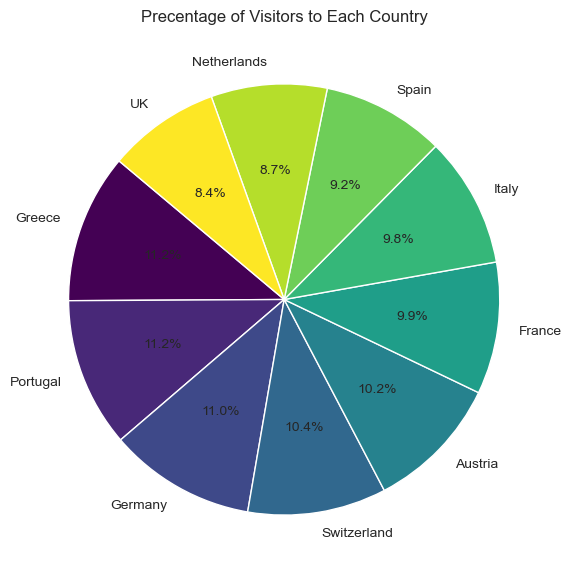

In [19]:


# Let's say you want to create a pie chart for the 'Main_Purpose' column
main_purpose_counts = df3['Country_Visited'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 7))
main_purpose_counts.plot.pie(autopct='%1.1f%%', startangle=140, cmap='viridis')
plt.title('Precentage of Visitors to Each Country')
plt.ylabel('')  # This removes the y-label
plt.savefig('pie_chart.png')
plt.show()

In [ ]:
conn.close()
engine.dispose()